# Day 7: Week 5 Review & Interview Questions
## Week 5: Portfolio Optimization

---

**Today's Focus:**
- Review all Week 5 concepts
- Practice interview questions
- Build complete portfolio optimizer
- Common interview scenarios

In [1]:
# Day 7 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RF_RATE = 0.05

print("=" * 60)
print("WEEK 5 REVIEW - PORTFOLIO OPTIMIZATION")
print("=" * 60)

WEEK 5 REVIEW - PORTFOLIO OPTIMIZATION


## 📚 Week 5 Concept Summary

### Day 1: Modern Portfolio Theory
- Markowitz mean-variance framework
- Efficient frontier construction
- Capital Market Line

### Day 2: Risk Measures
- Value at Risk (VaR): Parametric, Historical, Monte Carlo
- Expected Shortfall (CVaR)
- Risk contribution and risk parity

### Day 3: MVO in Practice
- Estimation error problems
- Shrinkage estimation (Ledoit-Wolf)
- Constraints: weight, sector, turnover

### Day 4: Black-Litterman
- Equilibrium returns
- Expressing and incorporating views
- Blending market wisdom with opinions

### Day 5: Backtesting
- Rolling window backtests
- Transaction cost modeling
- Performance metrics comparison

### Day 6: Factor Allocation
- Factor exposure analysis
- Target factor portfolios
- Multi-factor combination

In [2]:
# Load data for demonstrations
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)

assets = ['AAPL', 'MSFT', 'JPM', 'XOM', 'GLD', 'TLT']
prices = df[assets].dropna()
returns = prices.pct_change().dropna()

print(f"Data loaded: {len(returns)} days, {len(assets)} assets")

Data loaded: 1770 days, 6 assets


## 🎯 Interview Question 1: Portfolio Construction

**Q: Walk me through how you would construct an optimal portfolio for a client with moderate risk tolerance.**

In [3]:
# Complete portfolio construction example
print("=" * 60)
print("COMPLETE PORTFOLIO CONSTRUCTION")
print("=" * 60)

class PortfolioOptimizer:
    """Complete portfolio optimization framework."""
    
    def __init__(self, returns, rf_rate=RF_RATE):
        self.returns = returns
        self.rf_rate = rf_rate
        self.n_assets = returns.shape[1]
        self.assets = returns.columns.tolist()
        
        # Calculate statistics
        self.mean_returns = returns.mean() * TRADING_DAYS
        self.cov_matrix = returns.cov() * TRADING_DAYS
        self.std_returns = returns.std() * np.sqrt(TRADING_DAYS)
    
    def portfolio_stats(self, weights):
        """Calculate portfolio return, vol, sharpe."""
        ret = np.dot(weights, self.mean_returns)
        vol = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        sharpe = (ret - self.rf_rate) / vol
        return {'return': ret, 'volatility': vol, 'sharpe': sharpe}
    
    def min_variance(self, max_weight=0.4):
        """Find minimum variance portfolio."""
        def objective(w):
            return np.sqrt(np.dot(w.T, np.dot(self.cov_matrix, w)))
        
        constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        bounds = tuple((0, max_weight) for _ in range(self.n_assets))
        
        result = minimize(objective, np.array([1/self.n_assets]*self.n_assets),
                         method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x
    
    def max_sharpe(self, max_weight=0.4):
        """Find maximum Sharpe ratio portfolio."""
        def neg_sharpe(w):
            stats = self.portfolio_stats(w)
            return -stats['sharpe']
        
        constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        bounds = tuple((0, max_weight) for _ in range(self.n_assets))
        
        result = minimize(neg_sharpe, np.array([1/self.n_assets]*self.n_assets),
                         method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x
    
    def target_return(self, target, max_weight=0.4):
        """Find minimum variance portfolio for target return."""
        def objective(w):
            return np.sqrt(np.dot(w.T, np.dot(self.cov_matrix, w)))
        
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: np.dot(x, self.mean_returns) - target}
        ]
        bounds = tuple((0, max_weight) for _ in range(self.n_assets))
        
        result = minimize(objective, np.array([1/self.n_assets]*self.n_assets),
                         method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x
    
    def calculate_var(self, weights, confidence=0.95):
        """Calculate VaR and ES."""
        port_returns = self.returns.dot(weights)
        var = -np.percentile(port_returns, (1-confidence) * 100)
        es = -port_returns[port_returns <= -var].mean()
        return {'VaR': var * np.sqrt(TRADING_DAYS), 
                'ES': es * np.sqrt(TRADING_DAYS)}

# Run optimization
optimizer = PortfolioOptimizer(returns)

# Different portfolios
portfolios = {
    'Equal Weight': np.array([1/len(assets)] * len(assets)),
    'Min Variance': optimizer.min_variance(),
    'Max Sharpe': optimizer.max_sharpe(),
    'Target 10%': optimizer.target_return(0.10)
}

print("\n📊 Portfolio Comparison:")
print(f"{'Portfolio':<15} {'Return':>10} {'Vol':>10} {'Sharpe':>10}")
print("-" * 50)

for name, weights in portfolios.items():
    stats = optimizer.portfolio_stats(weights)
    print(f"{name:<15} {stats['return']:>10.2%} {stats['volatility']:>10.2%} {stats['sharpe']:>10.3f}")

# Show weights for recommended portfolio (target 10%)
print("\n📊 Recommended Portfolio (Target 10% Return):")
for asset, weight in zip(assets, portfolios['Target 10%']):
    if weight > 0.01:
        print(f"  {asset}: {weight:.1%}")

COMPLETE PORTFOLIO CONSTRUCTION

📊 Portfolio Comparison:
Portfolio           Return        Vol     Sharpe
--------------------------------------------------
Equal Weight        19.84%     15.36%      0.966
Min Variance        12.29%     10.35%      0.704
Max Sharpe          24.22%     16.26%      1.182
Target 10%          10.90%     13.62%      0.434

📊 Recommended Portfolio (Target 10% Return):
  XOM: 40.0%
  GLD: 20.0%
  TLT: 40.0%


## 🎯 Interview Question 2: Risk Management

**Q: How would you measure and manage risk for a portfolio?**

In [4]:
# Risk management demonstration
print("=" * 60)
print("RISK MANAGEMENT FRAMEWORK")
print("=" * 60)

# Use target 10% portfolio
weights = portfolios['Target 10%']
port_returns = returns.dot(weights)

# 1. VaR and ES
var_results = optimizer.calculate_var(weights, 0.95)
print("\n📊 Risk Measures (95% confidence):")
print(f"  Daily VaR: {-np.percentile(port_returns, 5):.2%}")
print(f"  Daily ES:  {-port_returns[port_returns <= np.percentile(port_returns, 5)].mean():.2%}")
print(f"  Annualized VaR: {var_results['VaR']:.2%}")
print(f"  Annualized ES: {var_results['ES']:.2%}")

# 2. Maximum Drawdown
cumulative = (1 + port_returns).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max

print(f"\n📊 Drawdown Analysis:")
print(f"  Maximum Drawdown: {drawdown.min():.2%}")
print(f"  Current Drawdown: {drawdown.iloc[-1]:.2%}")
print(f"  Avg Drawdown: {drawdown.mean():.2%}")

# 3. Risk Contribution
def risk_contribution(weights, cov_matrix):
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    mrc = np.dot(cov_matrix, weights) / port_vol
    rc = weights * mrc
    return rc / rc.sum()

rc = risk_contribution(weights, optimizer.cov_matrix.values)

print(f"\n📊 Risk Contribution:")
for asset, weight, contrib in zip(assets, weights, rc):
    if weight > 0.01:
        print(f"  {asset}: Weight={weight:.1%}, Risk Contrib={contrib:.1%}")

RISK MANAGEMENT FRAMEWORK

📊 Risk Measures (95% confidence):
  Daily VaR: 1.24%
  Daily ES:  1.88%
  Annualized VaR: 19.75%
  Annualized ES: 29.80%

📊 Drawdown Analysis:
  Maximum Drawdown: -24.29%
  Current Drawdown: -0.55%
  Avg Drawdown: -3.89%

📊 Risk Contribution:
  XOM: Weight=40.0%, Risk Contrib=74.7%
  GLD: Weight=20.0%, Risk Contrib=9.6%
  TLT: Weight=40.0%, Risk Contrib=15.7%


## 🎯 Interview Question 3: MVO Limitations

**Q: What are the main problems with mean-variance optimization and how do you address them?**

In [5]:
# MVO limitations demonstration
print("=" * 60)
print("MVO LIMITATIONS & SOLUTIONS")
print("=" * 60)

print("""
📋 MAIN PROBLEMS:

1. ESTIMATION ERROR
   - Expected returns are notoriously hard to estimate
   - Small changes in inputs → large changes in weights
   - MVO "maximizes" estimation errors

2. EXTREME WEIGHTS
   - Without constraints, produces concentrated portfolios
   - Often large short positions

3. INSTABILITY
   - Optimal portfolio changes dramatically over time
   - High turnover = high transaction costs

📋 SOLUTIONS:
""")

# Demonstrate solution: Constrained optimization
from sklearn.covariance import LedoitWolf

# Unconstrained
def unconstrained_max_sharpe(mean_ret, cov_mat, rf_rate):
    n = len(mean_ret)
    def neg_sharpe(w):
        ret = np.dot(w, mean_ret)
        vol = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
        return -(ret - rf_rate) / vol
    
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((-1, 2) for _ in range(n))  # Allow shorts
    
    result = minimize(neg_sharpe, np.array([1/n]*n), method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

# Sample covariance
sample_cov = returns.cov().values * TRADING_DAYS
mean_ret = returns.mean().values * TRADING_DAYS

# Shrunk covariance
lw = LedoitWolf().fit(returns)
shrunk_cov = lw.covariance_ * TRADING_DAYS

# Compare
print("Solution 1: SHRINKAGE ESTIMATION")
print(f"  Ledoit-Wolf shrinkage: {lw.shrinkage_:.3f}")
print(f"  Reduces condition number: {np.linalg.cond(sample_cov):.1f} → {np.linalg.cond(shrunk_cov):.1f}")

print("\nSolution 2: WEIGHT CONSTRAINTS")
unconstrained = unconstrained_max_sharpe(mean_ret, sample_cov, RF_RATE)
constrained = optimizer.max_sharpe(max_weight=0.4)

print(f"  Unconstrained max weight: {unconstrained.max():.1%}")
print(f"  Unconstrained min weight: {unconstrained.min():.1%}")
print(f"  Constrained range: {constrained.min():.1%} to {constrained.max():.1%}")

print("\nSolution 3: BLACK-LITTERMAN")
print("  Start from equilibrium (market cap weights)")
print("  Blend with views using confidence levels")
print("  More stable, intuitive weights")

print("\nSolution 4: ROBUST OPTIMIZATION")
print("  Account for input uncertainty")
print("  Penalize sensitivity to estimation errors")
print("  Resampling / Monte Carlo approaches")

MVO LIMITATIONS & SOLUTIONS

📋 MAIN PROBLEMS:

1. ESTIMATION ERROR
   - Expected returns are notoriously hard to estimate
   - Small changes in inputs → large changes in weights
   - MVO "maximizes" estimation errors

2. EXTREME WEIGHTS
   - Without constraints, produces concentrated portfolios
   - Often large short positions

3. INSTABILITY
   - Optimal portfolio changes dramatically over time
   - High turnover = high transaction costs

📋 SOLUTIONS:

Solution 1: SHRINKAGE ESTIMATION
  Ledoit-Wolf shrinkage: 0.022
  Reduces condition number: 12.0 → 11.1

Solution 2: WEIGHT CONSTRAINTS
  Unconstrained max weight: 98.0%
  Unconstrained min weight: -45.5%
  Constrained range: 0.0% to 40.0%

Solution 3: BLACK-LITTERMAN
  Start from equilibrium (market cap weights)
  Blend with views using confidence levels
  More stable, intuitive weights

Solution 4: ROBUST OPTIMIZATION
  Account for input uncertainty
  Penalize sensitivity to estimation errors
  Resampling / Monte Carlo approaches


## 🎯 Interview Question 4: Real-World Implementation

**Q: How would you actually implement portfolio optimization at a fund?**

In [6]:
# Production-ready optimizer
print("=" * 60)
print("PRODUCTION IMPLEMENTATION")
print("=" * 60)

class ProductionOptimizer:
    """Production-ready portfolio optimizer with all constraints."""
    
    def __init__(self, returns, config):
        self.returns = returns
        self.config = config
        self.n_assets = returns.shape[1]
        self.assets = returns.columns.tolist()
        
        # Use shrunk covariance
        lw = LedoitWolf().fit(returns)
        self.cov_matrix = lw.covariance_ * TRADING_DAYS
        self.mean_returns = returns.mean().values * TRADING_DAYS
    
    def optimize(self, current_weights=None, target_return=None):
        """Run constrained optimization."""
        if current_weights is None:
            current_weights = np.array([1/self.n_assets] * self.n_assets)
        
        def objective(w):
            # Minimize variance with turnover penalty
            variance = np.dot(w.T, np.dot(self.cov_matrix, w))
            turnover = np.sum(np.abs(w - current_weights))
            return variance + self.config['turnover_penalty'] * turnover
        
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Full investment
        ]
        
        # Target return constraint
        if target_return is not None:
            constraints.append({
                'type': 'eq',
                'fun': lambda x: np.dot(x, self.mean_returns) - target_return
            })
        
        # Maximum turnover constraint
        constraints.append({
            'type': 'ineq',
            'fun': lambda x: self.config['max_turnover'] - np.sum(np.abs(x - current_weights))
        })
        
        # Weight bounds
        bounds = tuple((self.config['min_weight'], self.config['max_weight']) 
                       for _ in range(self.n_assets))
        
        result = minimize(objective, current_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        
        return result.x, result.success
    
    def generate_report(self, weights, current_weights=None):
        """Generate optimization report."""
        if current_weights is None:
            current_weights = np.array([1/self.n_assets] * self.n_assets)
        
        ret = np.dot(weights, self.mean_returns)
        vol = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        sharpe = (ret - self.config['rf_rate']) / vol
        turnover = np.sum(np.abs(weights - current_weights))
        
        return {
            'Expected Return': ret,
            'Volatility': vol,
            'Sharpe Ratio': sharpe,
            'Turnover': turnover,
            'Est. Trading Cost': turnover * self.config['transaction_cost'],
            'Weights': dict(zip(self.assets, weights))
        }

# Configuration
config = {
    'min_weight': 0.0,
    'max_weight': 0.4,
    'max_turnover': 0.5,
    'turnover_penalty': 0.01,
    'transaction_cost': 0.001,
    'rf_rate': RF_RATE
}

# Run optimization
prod_optimizer = ProductionOptimizer(returns, config)
optimal_weights, success = prod_optimizer.optimize(target_return=0.08)

report = prod_optimizer.generate_report(optimal_weights)

print("\n📊 Optimization Report:")
print(f"  Success: {success}")
print(f"  Expected Return: {report['Expected Return']:.2%}")
print(f"  Volatility: {report['Volatility']:.2%}")
print(f"  Sharpe Ratio: {report['Sharpe Ratio']:.3f}")
print(f"  Turnover: {report['Turnover']:.2%}")
print(f"  Est. Trading Cost: {report['Est. Trading Cost']:.4%}")

print("\n📊 Optimal Weights:")
for asset, weight in report['Weights'].items():
    if weight > 0.01:
        print(f"  {asset}: {weight:.1%}")

PRODUCTION IMPLEMENTATION

📊 Optimization Report:
  Success: False
  Expected Return: 10.90%
  Volatility: 13.67%
  Sharpe Ratio: 0.432
  Turnover: 100.00%
  Est. Trading Cost: 0.1000%

📊 Optimal Weights:
  XOM: 40.0%
  GLD: 20.0%
  TLT: 40.0%


## 📝 Week 5 Interview Cheatsheet

### Key Formulas:

**Portfolio Return:** $\mu_p = w^T \mu$

**Portfolio Variance:** $\sigma_p^2 = w^T \Sigma w$

**Sharpe Ratio:** $SR = \frac{\mu_p - r_f}{\sigma_p}$

**Parametric VaR:** $VaR_\alpha = -\mu + z_\alpha \cdot \sigma$

**Black-Litterman:** $\mu_{BL} = [(\tau\Sigma)^{-1} + P'\Omega^{-1}P]^{-1}[(\tau\Sigma)^{-1}\pi + P'\Omega^{-1}Q]$

### Common Questions:

1. **"What is the efficient frontier?"**
   - Set of portfolios with maximum return for given risk
   - Or minimum risk for given return
   - Everything below is suboptimal

2. **"VaR vs Expected Shortfall?"**
   - VaR: Threshold loss at confidence level
   - ES: Average loss beyond VaR (more conservative)
   - ES is subadditive (VaR is not)

3. **"What is risk parity?"**
   - Each asset contributes equally to portfolio risk
   - Not equal weights, but equal risk contribution
   - Usually leads to higher bond allocation

4. **"Why Black-Litterman?"**
   - MVO is highly sensitive to expected returns
   - BL starts from equilibrium (stable baseline)
   - Can incorporate views with confidence levels
   - More intuitive, stable portfolios

### Practical Tips:
- Always use constraints (no unconstrained MVO)
- Consider transaction costs in optimization
- Use shrinkage for covariance estimation
- Rebalance at reasonable frequency (monthly/quarterly)
- Track multiple risk metrics, not just volatility

WEEK 5 SUMMARY


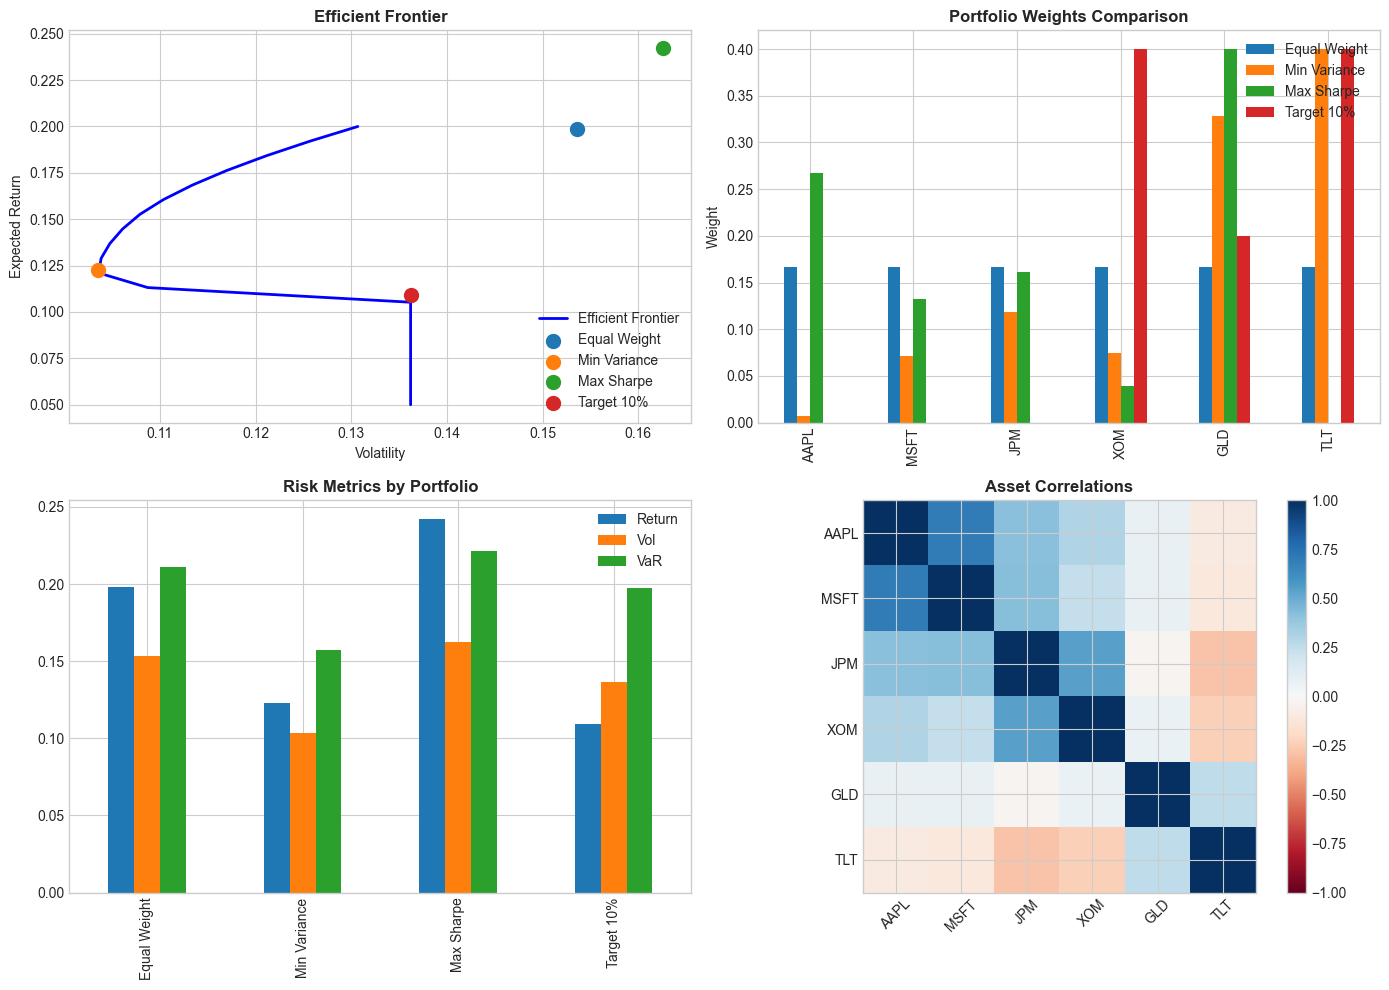


✅ Week 5 Complete!

Next Week: Factor Models


In [7]:
# Final summary visualization
print("=" * 60)
print("WEEK 5 SUMMARY")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Efficient frontier
target_returns = np.linspace(0.05, 0.20, 20)
frontier_vols = []

for target in target_returns:
    try:
        w = optimizer.target_return(target)
        vol = np.sqrt(np.dot(w.T, np.dot(optimizer.cov_matrix, w)))
        frontier_vols.append(vol)
    except:
        frontier_vols.append(np.nan)

axes[0, 0].plot(frontier_vols, target_returns, 'b-', linewidth=2, label='Efficient Frontier')

# Plot portfolios
for name, weights in portfolios.items():
    stats = optimizer.portfolio_stats(weights)
    axes[0, 0].scatter(stats['volatility'], stats['return'], s=100, label=name, zorder=5)

axes[0, 0].set_xlabel('Volatility')
axes[0, 0].set_ylabel('Expected Return')
axes[0, 0].set_title('Efficient Frontier', fontweight='bold')
axes[0, 0].legend(loc='lower right')

# 2. Weight comparison
weight_df = pd.DataFrame(portfolios, index=assets)
weight_df.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Portfolio Weights Comparison', fontweight='bold')
axes[0, 1].set_ylabel('Weight')
axes[0, 1].legend(loc='upper right')

# 3. Risk metrics
risk_metrics = ['Return', 'Vol', 'Sharpe', 'VaR']
risk_data = []
for name, weights in portfolios.items():
    stats = optimizer.portfolio_stats(weights)
    var = optimizer.calculate_var(weights, 0.95)['VaR']
    risk_data.append([stats['return'], stats['volatility'], stats['sharpe'], var])

risk_df = pd.DataFrame(risk_data, columns=risk_metrics, index=portfolios.keys())
risk_df[['Return', 'Vol', 'VaR']].plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Risk Metrics by Portfolio', fontweight='bold')
axes[1, 0].legend()

# 4. Correlation heatmap
corr = returns.corr()
im = axes[1, 1].imshow(corr, cmap='RdBu', vmin=-1, vmax=1)
axes[1, 1].set_xticks(range(len(assets)))
axes[1, 1].set_yticks(range(len(assets)))
axes[1, 1].set_xticklabels(assets, rotation=45)
axes[1, 1].set_yticklabels(assets)
axes[1, 1].set_title('Asset Correlations', fontweight='bold')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print("\n✅ Week 5 Complete!")
print("\nNext Week: Factor Models")